In [25]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Dropout, Conv2D, BatchNormalization
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D
from keras.layers import AveragePooling1D, MaxPooling1D, Conv1D, UpSampling1D, UpSampling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras import regularizers
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras.callbacks import ReduceLROnPlateau
# from keras.preprocessing.image import ImageDataGenerator
# from keras.regularizers import l2

In [3]:
# 300 sequences of 100-bits sequences
data_path = "data/viterbi_dump_k100_n300.pk"
data = pickle.load(open(data_path, "rb"))

In [4]:
print(list(data.keys()))

[(0.1, 0.05, 3), (0.1, 0.05, 5), (0.1, 0.1, 3), (0.1, 0.1, 5), (0.1, 0.15, 3), (0.1, 0.15, 5), (0.1, 0.2, 3), (0.1, 0.2, 5), (0.1, 0.3, 3), (0.1, 0.3, 5), (0.1, 0.5, 3), (0.1, 0.5, 5), (0.1, 0.8, 3), (0.1, 0.8, 5), (0.5, 0.05, 3), (0.5, 0.05, 5), (0.5, 0.1, 3), (0.5, 0.1, 5), (0.5, 0.15, 3), (0.5, 0.15, 5), (0.5, 0.2, 3), (0.5, 0.2, 5), (0.5, 0.3, 3), (0.5, 0.3, 5), (0.5, 0.5, 3), (0.5, 0.5, 5), (0.5, 0.8, 3), (0.5, 0.8, 5), (0.81, 0.05, 3), (0.81, 0.05, 5), (0.81, 0.1, 3), (0.81, 0.1, 5), (0.81, 0.15, 3), (0.81, 0.15, 5), (0.81, 0.2, 3), (0.81, 0.2, 5), (0.81, 0.3, 3), (0.81, 0.3, 5), (0.81, 0.5, 3), (0.81, 0.5, 5), (0.81, 0.8, 3), (0.81, 0.8, 5)]


In [5]:
message_seqs = list()
noisy_seqs = list()
viterbi_decoded_seqs = list()

In [6]:
for k, d in data.items():
#     if k[1] > 0.5:
#         continue
    message_seqs.append(d[0])
    noisy_seqs.append(d[1])
    viterbi_decoded_seqs.append(d[2])

In [7]:
message_seqs = np.concatenate(np.array(message_seqs))
noisy_seqs = np.concatenate(np.array(noisy_seqs))
viterbi_decoded_seqs = np.concatenate(np.array(viterbi_decoded_seqs))

In [8]:
print(message_seqs.shape)
print(noisy_seqs.shape)
print(viterbi_decoded_seqs.shape)

(12600, 100)
(12600,)
(12600,)


In [9]:
# noisy sequences have two lengths
np.unique([len(x) for x in noisy_seqs])

array([204, 208])

In [10]:
# viterbi_decoded sequences have two lengths
np.unique([len(x) for x in viterbi_decoded_seqs])

array([102, 104])

#### It seems that noisy sequences and viterbi decoding outputs various length sequences, but generally the additional bytes at the end are preample

In [11]:
idx = np.random.randint(low=0, high=len(message_seqs))
message_seqs[idx]

array([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])

In [12]:
viterbi_decoded_seqs[idx].astype("float64")

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0.])

In [13]:
def avg_loss(ground_truth, decodes):
    if len(ground_truth) != len(decodes):
        raise ValueError("ground_truth and decodes have different length: {0} and {1}"
                            .format(len(ground_truth), len(decodes)))
    l = 0.0
    for g, d in zip(ground_truth, decodes):
        l += sum(abs(g - d[:len(g)]))
    return l / len(ground_truth)

In [14]:
avg_loss(message_seqs, viterbi_decoded_seqs)

33.90396825396825

## Input Length Standardization

In [15]:
# noisy sequences have two lengths
np.unique([len(x) for x in noisy_seqs])

array([204, 208])

In [16]:
# viterbi_decoded sequences have two lengths
np.unique([len(x) for x in viterbi_decoded_seqs])

array([102, 104])

In [17]:
# standarlize length of noisy_inputs
noisy_seqs_sameLength = np.array([x if len(x) == 208 else np.concatenate([x, [0,0,0,0]]) 
                                      for x in noisy_seqs])

In [18]:
# Now input lengths are standardized
print(message_seqs.shape)
print(noisy_seqs_sameLength.shape)

(12600, 100)
(12600, 208)


## Model

In [19]:
X = noisy_seqs_sameLength.astype("float64")
Y = message_seqs.astype("float64")

In [20]:
indicies = np.arange(len(X))
np.random.shuffle(indicies)
indicies

array([2981, 6085, 4588, ..., 1024, 7583, 6264])

In [21]:
train_test_split = 0.2
split_idx = int(len(X) * (1 - train_test_split))

In [22]:
X_train, X_test = X[indicies[:split_idx]], X[indicies[split_idx:]]
Y_train, Y_test = Y[indicies[:split_idx]], Y[indicies[split_idx:]]
viterbi_decoded_train = [x[:100] for x in viterbi_decoded_seqs[indicies[:split_idx]]]
viterbi_decoded_test = [x[:100] for x in viterbi_decoded_seqs[indicies[split_idx:]]]

In [23]:
model = Sequential()
model.add(Dense(64,  activation=None, input_shape=(208,), 
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(128, activation=None, 
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(256, activation=None, 
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(128, activation=None, 
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(100, activation="sigmoid"))

In [295]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=1, 
          validation_split=0.2, shuffle=True)

In [422]:
def threshold(preds):
    result = []
    for pred in preds:
        result.append([1 if x >= 0.5 else 0 for x in pred])
    return np.array(result).astype("float64")
def test(input_x, target_label, viterbi_output, test_model):
    viterbi_avg_loss = avg_loss(target_label, viterbi_output)
    model_avg_loss = avg_loss(target_label, threshold(test_model.predict(input_x)))
    print("average loss for viterbi decoding is: {0:.4f}; acc {1:.4f}".format(
                viterbi_avg_loss, 1 - viterbi_avg_loss/input_x.shape[1]))
    print("average loss for model is: {0:.4f}; acc {1:.4f}".format(
                model_avg_loss, 1 - model_avg_loss/input_x.shape[1]))
    print("## Random Example ##")
    test_idx = np.random.randint(0, high=len(input_x))
    test_truth = target_label[test_idx]
    #test_pred = test_model.predict(input_x[test_idx:test_idx+1])[0]
    test_pred_thresholded = threshold(test_model.predict(input_x[test_idx:test_idx+1]))[0]
    diff = abs(test_pred_thresholded - test_truth)
    print("ground_truth\n", test_truth)
    #print("prediction\n", test_pred)
    print("prediction_thresholded\n", test_pred_thresholded)
    print("DIFFERENCE (acc {0:.4f}%)\n".format(1-sum(diff)/len(test_pred_thresholded)), diff)
    print("dummy baseline (set every bit to the most occuring bit) can get {0}% accurate".format(
                max(sum(test_truth), 100-sum(test_truth))))

In [ ]:
test(X_test, Y_test, viterbi_decoded_test, model)

## Test various feedforward networks

In [386]:
FF_MODELS = [
    [32, 100],
    [64, 100],
    [128, 100],
    [256, 100],
    [32, 32, 100],
    [32, 64, 100],
    [64, 64, 100],
    [64, 128, 100],
    [128, 128, 100],
    [128, 256, 100],
    [256, 256, 100],
    [32,128,128,100],
    [32,128,256,100],
    [32,256,256,100],
    [32,128,256,128,100],
    [32,128,128,128,100],
    [1024,512,100],
    [512,256,100],
    [256,128,100],
    [128,100,100]
]

ACTIVATIONS = [None, "relu"]
L2 = 1e-7
BATCH_SIZE = 128
EPOCHS = 100
VALIDATION_RATIO = 0.2

In [387]:
def fnn_build_and_evaluate_performance(layers, activation="None", verbose=2, 
                                   input_shape=(208,), validation_split=VALIDATION_RATIO):
    if layers[-1] != 100:
        raise ValueError("last output dimension has to be 100")
    
    model = Sequential()
    for i, hidden_units in enumerate(layers):
        if i == 0:
            model.add(Dense(hidden_units, activation=activation, 
                            input_shape=input_shape, kernel_regularizer=regularizers.l2(L2)))
        elif i == len(layers) - 1:
            model.add(Dense(hidden_units, activation="sigmoid",
                           kernel_regularizer=regularizers.l2(L2)))
        else:
            model.add(Dense(100, activation=activation, kernel_regularizer=regularizers.l2(L2)))
            
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    
    model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
              validation_split=validation_split, shuffle=True)
    
    return model, avg_loss(Y_test, threshold(model.predict(X_test)))

In [388]:
def name(lst, act):
    return "[{0}]-{1}".format(",".join([str(x) for x in lst]), act)

In [389]:
from tqdm import tqdm

In [390]:
results = dict()
for m in FF_MODELS:
    for a in ACTIVATIONS:
        k = name(m, a)
        model, loss = fnn_build_and_evaluate_performance(m, activation=a, verbose=0)
        results[k] = (model, loss)
        print("{0} loss: {1:.4f}".format(k, loss))

[32,100]-None loss: 39.1067
[32,100]-relu loss: 39.3381
[64,100]-None loss: 40.0048
[64,100]-relu loss: 39.3159
[128,100]-None loss: 39.7810
[128,100]-relu loss: 38.8710
[256,100]-None loss: 39.4921
[256,100]-relu loss: 39.0508
[32,32,100]-None loss: 39.0020
[32,32,100]-relu loss: 39.1937
[32,64,100]-None loss: 39.2079
[32,64,100]-relu loss: 39.2833
[64,64,100]-None loss: 40.3151
[64,64,100]-relu loss: 36.6774
[64,128,100]-None loss: 39.8548
[64,128,100]-relu loss: 36.5746
[128,128,100]-None loss: 39.2095
[128,128,100]-relu loss: 36.5591
[128,256,100]-None loss: 39.9813
[128,256,100]-relu loss: 36.6901
[256,256,100]-None loss: 39.6996
[256,256,100]-relu loss: 37.2758
[32,128,128,100]-None loss: 38.5710
[32,128,128,100]-relu loss: 37.6992
[32,128,256,100]-None loss: 38.8147
[32,128,256,100]-relu loss: 36.9992
[32,256,256,100]-None loss: 38.5742
[32,256,256,100]-relu loss: 37.4948
[32,128,256,128,100]-None loss: 39.4413
[32,128,256,128,100]-relu loss: 36.9464
[32,128,128,128,100]-None lo

In [423]:
test(X_test, Y_test, viterbi_decoded_test, results["[128,128,100]-relu"][0])

average loss for viterbi decoding is: 33.9929; acc 0.8366
average loss for model is: 36.5591; acc 0.8242
## Random Example ##
ground_truth
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1.]
prediction_thresholded
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 0.]
DIFFERENCE (acc 0.4600%)
 [0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 

In [396]:
best_model = results["[128,128,100]-relu"][0]

In [397]:
best_model.save("models/ecc-fnn-128-128-100-relu.h5")

In [409]:
L2 = 1e-7
BATCH_SIZE = 128
EPOCHS = 100
VALIDATION_RATIO = 0.2
model, loss = fnn_build_and_evaluate_performance([100,100,100], activation="relu", verbose=2)

Train on 8064 samples, validate on 2016 samples
Epoch 1/100
 - 9s - loss: 0.2491 - acc: 0.0097 - val_loss: 0.2454 - val_acc: 0.0045
Epoch 2/100
 - 0s - loss: 0.2363 - acc: 0.0403 - val_loss: 0.2295 - val_acc: 0.0119
Epoch 3/100
 - 0s - loss: 0.2213 - acc: 0.0435 - val_loss: 0.2236 - val_acc: 0.0565
Epoch 4/100
 - 0s - loss: 0.2133 - acc: 0.0668 - val_loss: 0.2196 - val_acc: 0.0570
Epoch 5/100
 - 0s - loss: 0.2062 - acc: 0.0809 - val_loss: 0.2149 - val_acc: 0.0799
Epoch 6/100
 - 0s - loss: 0.1986 - acc: 0.1173 - val_loss: 0.2139 - val_acc: 0.0283
Epoch 7/100
 - 0s - loss: 0.1930 - acc: 0.0784 - val_loss: 0.2119 - val_acc: 0.0769
Epoch 8/100
 - 0s - loss: 0.1880 - acc: 0.1017 - val_loss: 0.2117 - val_acc: 0.0655
Epoch 9/100
 - 0s - loss: 0.1845 - acc: 0.0996 - val_loss: 0.2119 - val_acc: 0.0694
Epoch 10/100
 - 0s - loss: 0.1813 - acc: 0.0914 - val_loss: 0.2128 - val_acc: 0.0759
Epoch 11/100
 - 0s - loss: 0.1787 - acc: 0.0720 - val_loss: 0.2160 - val_acc: 0.1195
Epoch 12/100
 - 0s - loss:

Epoch 97/100
 - 0s - loss: 0.1537 - acc: 0.1317 - val_loss: 0.2402 - val_acc: 0.0942
Epoch 98/100
 - 0s - loss: 0.1536 - acc: 0.1312 - val_loss: 0.2416 - val_acc: 0.1032
Epoch 99/100
 - 0s - loss: 0.1536 - acc: 0.1291 - val_loss: 0.2410 - val_acc: 0.0972
Epoch 100/100
 - 0s - loss: 0.1535 - acc: 0.1298 - val_loss: 0.2407 - val_acc: 0.0977


In [432]:
test(X_test, Y_test, viterbi_decoded_test, model)

average loss for viterbi decoding is: 33.9929; acc 0.8366
average loss for model is: 36.7734; acc 0.8232
## Random Example ##
ground_truth
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1.]
prediction_thresholded
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 1.]
DIFFERENCE (acc 0.4600%)
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 

##### Observation: The model overfits always by guessing everything to be the value of the most dominating digits

## Convolutional Neural Net

In [685]:
X_train_cnn = X_train.reshape((-1, 13, 16, 1))
Y_train_cnn = Y_train.reshape((-1, 100))

X_test_cnn = X_test.reshape((-1, 13, 16, 1))
Y_test_cnn = Y_test.reshape((-1, 100))

input_shape=(13, 16, 1)

In [794]:
ACTIVATION = "linear"
PADDING = "same"

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=3, strides=1,padding=PADDING, 
                 activation=ACTIVATION, input_shape=input_shape))
model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding=PADDING, activation=ACTIVATION))

model.add(AveragePooling2D(pool_size=4, strides=None, padding=PADDING))
#model.add(MaxPooling2D(pool_size=4, strides=None, padding='same'))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding=PADDING, activation=ACTIVATION))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding=PADDING, activation=ACTIVATION))

#model.add(AveragePooling2D(pool_size=3, strides=None, padding=PADDING))
#model.add(MaxPooling2D(pool_size=2, strides=None, padding='same'))

model.add(Flatten())

model.add(Dense(128, activation=ACTIVATION))
model.add(Dropout(0.5))

# model.add(Dense(100, activation=ACTIVATION))
# model.add(Dropout(0.4))

model.add(Dense(100, activation="sigmoid"))

In [795]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [796]:
model.fit(X_train_cnn, Y_train_cnn, batch_size=32, epochs=40, verbose=2, 
          validation_split=0.2, shuffle=True)

Train on 8064 samples, validate on 2016 samples
Epoch 1/40
 - 11s - loss: 0.2446 - acc: 0.0069 - val_loss: 0.2381 - val_acc: 0.0025
Epoch 2/40
 - 3s - loss: 0.2385 - acc: 0.0123 - val_loss: 0.2347 - val_acc: 0.0055
Epoch 3/40
 - 3s - loss: 0.2361 - acc: 0.0445 - val_loss: 0.2334 - val_acc: 0.0541
Epoch 4/40
 - 3s - loss: 0.2349 - acc: 0.0755 - val_loss: 0.2331 - val_acc: 0.1111
Epoch 5/40
 - 3s - loss: 0.2344 - acc: 0.0919 - val_loss: 0.2333 - val_acc: 0.0694
Epoch 6/40
 - 3s - loss: 0.2343 - acc: 0.0851 - val_loss: 0.2322 - val_acc: 0.1726
Epoch 7/40
 - 3s - loss: 0.2334 - acc: 0.0991 - val_loss: 0.2323 - val_acc: 0.0997
Epoch 8/40
 - 4s - loss: 0.2334 - acc: 0.0776 - val_loss: 0.2349 - val_acc: 0.0719
Epoch 9/40
 - 3s - loss: 0.2333 - acc: 0.1022 - val_loss: 0.2322 - val_acc: 0.0645
Epoch 10/40
 - 3s - loss: 0.2331 - acc: 0.0787 - val_loss: 0.2321 - val_acc: 0.1424
Epoch 11/40
 - 3s - loss: 0.2328 - acc: 0.0910 - val_loss: 0.2318 - val_acc: 0.1721
Epoch 12/40
 - 3s - loss: 0.2328 - a

In [805]:
test_idx = np.random.randint(0, high=len(X_test_cnn))
tmp = model.predict(X_test_cnn[test_idx:test_idx+1]).reshape(1,100)

test_true = Y_test_cnn[test_idx:test_idx+1][0]
test_pred = threshold(tmp)[0]

print("true\n", test_true)
print("pred\n", test_pred)
print("accu {0}%".format(sum(test_true == test_pred)))

true
 [0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
pred
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1.]
accu 70%


In [806]:
# tmodel.save("models/ecc-cnn1.h5")

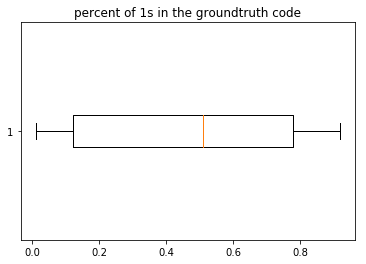

In [792]:
plt.title("percent of 1s in the groundtruth code")
_ = plt.boxplot([sum(x)/100 for x in Y_test], vert=False,)

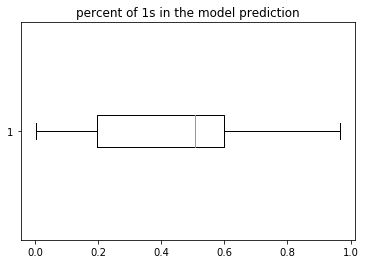

In [793]:
plt.title("percent of 1s in the model prediction")
_ = plt.boxplot([sum(x)/100 for x in model.predict(X_test_cnn)], vert=False)

## Autoencoder

In [26]:
X_train_cnn = X_train.reshape((-1, 208, 1)) # 208
Y_train_cnn = Y_train.reshape((-1, 100))

X_test_cnn = X_test.reshape((-1, 208, 1))
Y_test_cnn = Y_test.reshape((-1, 100))

input_shape=(208, 1)

In [31]:
ACTIVATION = "relu"
PADDING = "same"

model = Sequential()

# 208 x 1
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, 
                 activation=ACTIVATION, input_shape=input_shape))
# 208 x 16
model.add(MaxPooling1D(pool_size=2, strides=None, padding='same'))
# 104 x 16
model.add(Conv1D(filters=8, kernel_size=3, strides=1, padding=PADDING, activation=ACTIVATION))
# 104 x 8
model.add(MaxPooling1D(pool_size=2, strides=None, padding='same'))
# 52 x 8

model.add(UpSampling1D(size=2))
# 104 x 8
model.add(Conv1D(filters=8, kernel_size=3, strides=1, padding=PADDING, activation=ACTIVATION))
# 104 x 8
model.add(UpSampling1D(size=2))
# 208 x 8
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding=PADDING, activation=ACTIVATION))
# 208 x 16

model.add(Flatten())
# 3328

model.add(Dense(1024, activation=ACTIVATION))
model.add(Dropout(0.5))

model.add(Dense(526, activation=ACTIVATION))
model.add(Dropout(0.5))

model.add(Dense(128, activation=ACTIVATION))
model.add(Dropout(0.5))

model.add(Dense(100, activation="sigmoid"))

In [32]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train_cnn, Y_train_cnn, batch_size=32, epochs=20, verbose=2, 
          validation_split=0.2, shuffle=True)

Train on 8064 samples, validate on 2016 samples
Epoch 1/20
 - 16s - loss: 0.2357 - acc: 0.0105 - val_loss: 0.2209 - val_acc: 4.9603e-04
Epoch 2/20
 - 15s - loss: 0.2183 - acc: 0.0071 - val_loss: 0.2155 - val_acc: 0.0000e+00
Epoch 3/20
 - 15s - loss: 0.2137 - acc: 0.0117 - val_loss: 0.2148 - val_acc: 0.0223
Epoch 4/20
 - 15s - loss: 0.2111 - acc: 0.0081 - val_loss: 0.2141 - val_acc: 0.0020
Epoch 5/20
 - 16s - loss: 0.2075 - acc: 0.0078 - val_loss: 0.2118 - val_acc: 0.0020
Epoch 6/20
 - 16s - loss: 0.2036 - acc: 0.0057 - val_loss: 0.2087 - val_acc: 9.9206e-04
Epoch 7/20
 - 15s - loss: 0.1983 - acc: 0.0114 - val_loss: 0.2103 - val_acc: 0.0020
Epoch 8/20


KeyboardInterrupt: 